In [1]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalDeathsModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
PROJECT_PATH = Path.cwd().resolve()
DATA_PATH = PROJECT_PATH.parent / "data/covid_aus"

In [3]:
# Get data
target_data = pd.read_csv(DATA_PATH / "WHO-COVID-19-global-data_21_8_24.csv")
seroprev_data = pd.read_csv(DATA_PATH / "aus_seroprev_data.csv")

# Clean cases data
aust_data = target_data.loc[target_data["Country"] == "Australia"]
aust_data.index = pd.to_datetime(aust_data["Date_reported"], format="%d/%m/%Y")
aust_cases = aust_data["New_cases"].resample("W-SUN").interpolate(method="linear").fillna(0.0)
aust_deaths = aust_data["New_deaths"]

# Clean seroprevalence data
seroprev_data.index = pd.to_datetime(seroprev_data["date"])
aust_seroprev = seroprev_data["seroprevalence"]

In [4]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
pop = 26e6
analysis_start = datetime(2021, 12, 1)
analysis_end = datetime(2022, 10, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = aust_cases.loc[analysis_start: analysis_end]
select_deaths = aust_deaths.loc[analysis_start: analysis_end]
init_data = aust_cases.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [5]:
# Define model and fitter
proc_fitter = CosineMultiCurve()
renew_model = RenewalDeathsModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [17]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(15, 15), #(16,40)
    "ifr": dist.Beta(3, 20),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3, 0.5, low=1.0),
    "death_mean": dist.TruncatedNormal(18.0, 0.5, low=1.0),
    "death_sd": dist.TruncatedNormal(5.0, 0.5, low=1.0),
}

In [70]:
# Define calibration and calib data
calib_data = {
    "weekly_sum": select_data,
    "seropos": aust_seroprev,
    "weekly_deaths": select_deaths,
}
calib = StandardCalib(renew_model, priors, calib_data)

In [57]:
# Run calibration
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=100, num_warmup=100)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [58]:
# Grab sample of data from calibrated model outputs
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=800)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [59]:
# get model results and outputs
def get_full_result(**params):
    return renew_model.renewal_func(**params)

full_wrap = jit(get_full_result)

In [32]:
PANEL_SUBTITLES[1:]

['susceptibles', 'R', 'transmission potential']

In [67]:
panel_subtitles = ['weekly_deaths', 'seropos', 'weekly_sum','R'] #    + PANEL_SUBTITLES[1:]
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles)

In [54]:
quantiles_df

weekly_deaths                                  seropos  \
                    0.05        0.50        0.95             0.05   
2021-12-01     40.398551   43.856643   47.463726  25799525.272858   
2021-12-02     40.118715   43.558936   47.140173   25794842.72943   
2021-12-03     39.877339   43.333352   46.905432  25789930.626353   
2021-12-04      39.68573   43.195741   46.749072  25784812.228475   
2021-12-05     39.561743   43.119536   46.632169   25779456.88779   
...                  ...         ...         ...              ...   
2022-09-27    120.473918   142.22187  168.566831  18569606.747695   
2022-09-28    116.093549  139.434411  169.008835  18566640.972909   
2022-09-29    110.972551   136.30709  169.842801  18563828.121037   
2022-09-30    106.092216  133.317439  168.729323  18553053.129089   
2022-10-01    100.264413  130.920376  168.888384  18539887.471996   

                                             weekly_sum                      \
                       0.50             0.95       0.05      0.50      0.95   
2021-12-01   25846546.22617  25875703.861578   1.241704  1.351709  1.470553   
2021-12-02  25843069.648106  25872865.222974   1.241558  1.351503  1.470351   
2021-12-03  25839537.513799  25869960.386301   1.241411  1.351294  1.470146   
2021-12-04   25835914.79941   25866952.45266   1.241261  1.351079  1.469936   
2021-12-05  25832168.901453  25863815.962993   1.241108  1.350857  1.469718   
...                     ...              ...        ...       ...       ...   
2022-09-27  20318049.803495   21504027.56509   0.504447  0.930641    1.4503   
2022-09-28   20314531.28567  21499754.301652   0.505065  0.938027  1.480973   
2022-09-29  20311100.540711   21495489.84635   0.492517  0.943624  1.505493   
2022-09-30  20307752.535908  21491242.672434   0.486605   0.94062  1.525502   
2022-10-01  20304484.353163  21487023.794575   0.484175  0.939337  1.531474   

                   R                      
                0.05      0.50      0.95  
2021-12-01  1.248577   1.35899  1.478637  
2021-12-02  1.248577   1.35899  1.478637  
2021-12-03  1.248577   1.35899  1.478637  
2021-12-04  1.248577   1.35899  1.478637  
2021-12-05  1.248577   1.35899  1.478637  
...              ...       ...       ...  
2022-09-27  0.650385  1.200331  1.839955  
2022-09-28    0.6397  1.206488  1.884997  
2022-09-29  0.629252  1.215376  1.927635  
2022-09-30  0.626244  1.216809  1.954799  
2022-10-01  0.624518  1.218298  1.964094  

[305 rows x 12 columns]

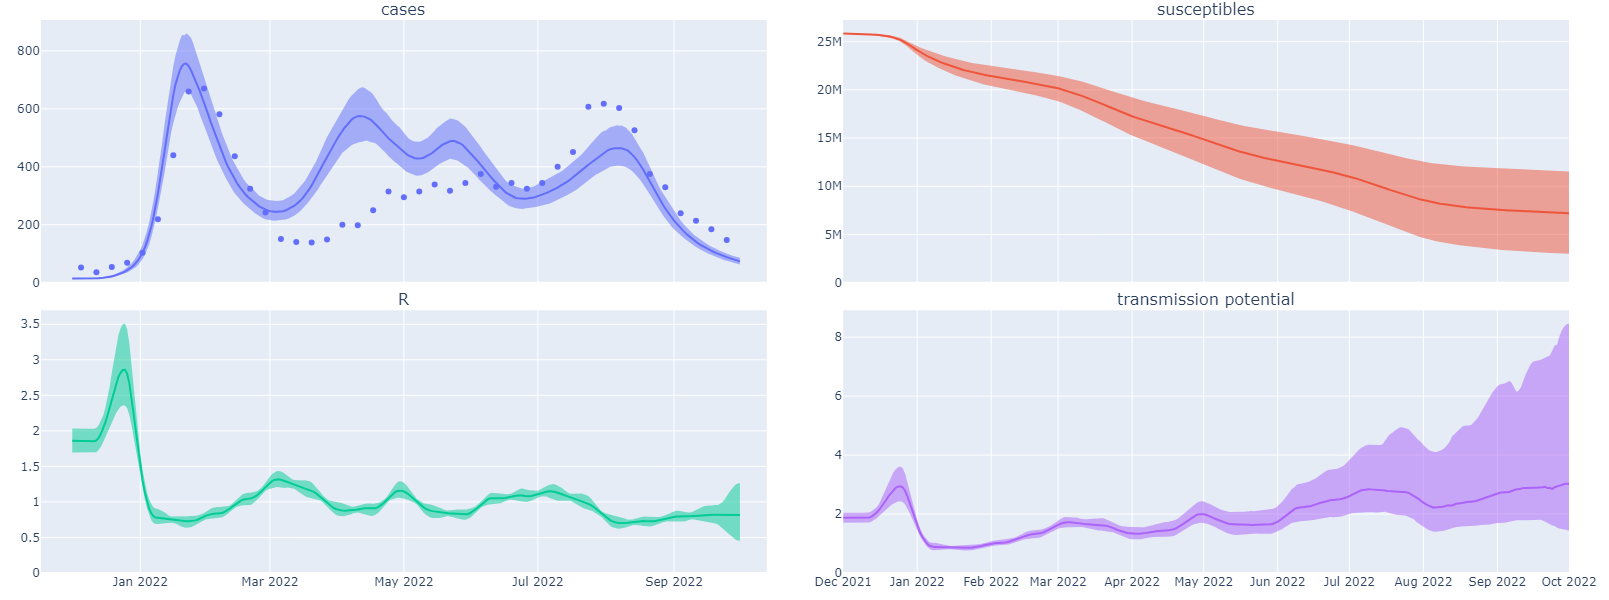

In [69]:
plot_uncertainty_patches(quantiles_df, select_deaths, qual_colours.Plotly, panel_subtitles).update_layout(showlegend=False)

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.597,0.034,0.539,0.670,0.004,0.003,99.0,59.0,1.02
death_mean,18.096,0.477,17.124,18.837,0.033,0.023,209.0,225.0,1.00
death_sd,5.132,0.506,4.214,6.048,0.041,0.029,153.0,229.0,1.01
dispersion_seropos,0.097,0.045,0.032,0.179,0.004,0.003,133.0,149.0,1.00
dispersion_weekly_deaths,0.442,0.037,0.365,0.506,0.003,0.002,198.0,54.0,1.03
dispersion_weekly_sum,0.074,0.012,0.055,0.098,0.001,0.001,144.0,97.0,0.99
gen_mean,6.510,0.534,5.410,7.494,0.050,0.035,115.0,107.0,1.01
gen_sd,4.179,0.526,3.100,5.055,0.035,0.025,218.0,131.0,1.03
ifr,0.001,0.000,0.001,0.001,0.000,0.000,104.0,178.0,1.02
proc[0],0.447,0.119,0.222,0.688,0.010,0.007,141.0,97.0,1.00


In [ ]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);